#Multi-Class Object Detection with using Faster-RCNN

##Import utilities

In [ ]:
!pip install pycocotools --quiet

In [ ]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

Cloning into 'vision'...
remote: Enumerating objects: 332260, done.
remote: Counting objects: 100% (67170/67170), done.
remote: Compressing objects: 100% (1004/1004), done.
remote: Total 332260 (delta 66698), reused 66510 (delta 66147), pack-reused 265090
Receiving objects: 100% (332260/332260), 671.90 MiB | 15.34 MiB/s, done.
Resolving deltas: 100% (305792/305792), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
import os
import xml.etree.ElementTree as ET
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision.transforms import Compose

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Resize, Normalize
# from my_dataset import MyDataset # custom dataset class
from vision.references.detection import utils

import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# import multiprocessing as mp
# mp.set_start_method('spawn')

In [ ]:
from vision.references.detection import engine
from vision.references.detection.engine import train_one_epoch

## Dataset

In [ ]:
# # Define class labels and their corresponding label-encoded values
# class_labels = {
#     'Neutrophil': 0,
#     'Large Lymph': 1,
#     'Monocyte': 2,
#     'Small Lymph': 3,
#     'Eosinophil': 4,
#     'Unknn' : 5, 'Artifact' :6, 'Burst':7, 'Band': 8 }

# class_labels_id = {
#      0 : 'Neutrophil',
#      1 : 'Large Lymph',
#      2 : 'Monocyte',
#      3 : 'Small Lymph',
#      4 : 'Eosinophil',
#      5 : 'Unknn', 6 : 'Artifact', 7 : 'Burst', 8 : 'Band',
# }

In [ ]:
# Define class labels and their corresponding label-encoded values
class_labels = {
    'Neutrophil': 0,
    'Large Lymph': 1,
    'Monocyte': 2,
    'Small Lymph': 3,
    'Eosinophil': 4,
    }

class_labels_id = {
     0 : 'Neutrophil',
     1 : 'Large Lymph',
     2 : 'Monocyte',
     3 : 'Small Lymph',
     4 : 'Eosinophil',
     }

In [ ]:
def convert_annotation(xml_file, output_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    # image_size = (root.find('size/width').text, root.find('size/height').text)


    for obj in root.findall('object'):
        name = obj.find('name').text
        if name in class_labels:
            label = class_labels[name]

            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)

            bbox = (xmin, ymin, xmax, ymax)

            with open(output_file, 'w') as f:
              # converted_bbox = convert_coordinates(image_size, bbox)
              line = f"{label} {' '.join(str(coord) for coord in bbox)}\n"
              f.write(line)


In [ ]:
# Set paths
xml_dir = '/content/drive/MyDrive/customTF2/annotations'
output_dir = '/content/datasets/annotations'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Convert XML files to YOLOv5 format with label encoding
for xml_file in os.listdir(xml_dir):
    if xml_file.endswith('.xml'):
        xml_path = os.path.join(xml_dir, xml_file)
        output_file = os.path.join(output_dir, xml_file.replace('.xml', '.txt'))
        convert_annotation(xml_path, output_file)

In [ ]:
for filename in os.listdir('/content/datasets/annotations'):
  img_name = filename.replace('.txt', '.jpg')
  source_path = os.path.join('/content/drive/MyDrive/customTF2/images', img_name)
  dest_path = os.path.join('/content/datasets/images', img_name)
  shutil.copy(source_path, dest_path)

FileNotFoundError: ignored

In [ ]:
shutil.copytree('/content/drive/MyDrive/customTF2/images', '/content/datasets/images')

'/content/datasets/images'

In [ ]:
class MyDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = []
        self.annotations = []

        for filename in os.listdir(os.path.join(root, 'images')):
            if filename.endswith('.jpg'):
                self.imgs.append(os.path.join(root, 'images', filename))
                annotation_file = os.path.join(root, 'annotations', f'{filename[:-4]}.txt')
                with open(annotation_file, 'r') as f:
                    img_annotations = []
                    for line in f.readlines():
                        bbox = line[1:]
                        label = line[0]
                        img_annotations.append({
                            'bbox': bbox,
                            'label': label
                        })
                self.annotations.append(img_annotations)

        # Define the image transformation pipeline
        if self.transforms is not None:
            self.transforms = torchvision.transforms.Compose([
                Resize((256, 256)),  # Resize the image to a specific size
                ToTensor(),  # Convert the image to a tensor
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
            ])

    def __getitem__(self, idx):
        # Load image and annotations
        img_path = self.imgs[idx]
        annotations = self.annotations[idx]

        img = Image.open(img_path).convert('RGB')
        width, height = img.size

        # Apply transforms to image
        if self.transforms is not None:
            img = self.transforms(img)

        # Get image size after resizing
        # img_height, img_width = img.shape[-2:]

        # Convert annotations to tensors and resize bounding boxes
        boxes = []
        labels = []
        for annotation in annotations:
            bbox = [float(coord) for coord in annotation['bbox'].split()]

            # Normalize the bounding box coordinates
            bbox[0] *= (256 / width)  # xmin
            bbox[1] *= (256 / height)  # ymin
            bbox[2] *= (256 / width)  # xmax
            bbox[3] *= (256 / height)  # ymax

                    # Resize the bounding boxes
            # new_x1 = x1 * (256 / width)
            # new_y1 = y1 * (256 / height)
            # new_x2 = x2 * (256 / width)
            # new_y2 = y2 * (256 / height)

            boxes.append(torch.tensor(bbox, dtype=torch.float32))
            labels.append(torch.tensor(int(annotation['label']), dtype=torch.int64))

        # Stack the tensors
        boxes = torch.stack(boxes)
        labels = torch.stack(labels)

        return img, {
            'boxes': boxes,
            'labels': labels,
        }

    def __len__(self):
        return len(self.imgs)

In [ ]:
# define the dataset and data loader
dataset = MyDataset(root='/content/datasets', transforms=transforms.Compose([transforms.ToTensor()]))


{'boxes': tensor([[ 74.4578, 135.4538, 102.1687, 184.7175]]), 'labels': tensor([4])}


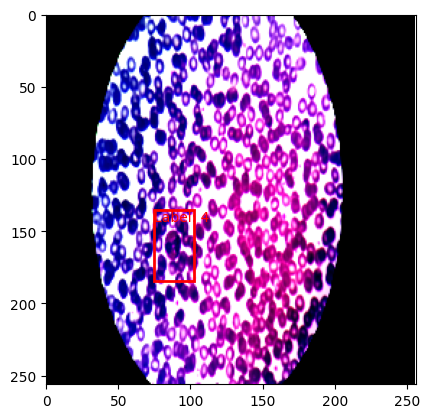

In [ ]:
# Assuming you have an image and bounding boxes
image, annotations = dataset[11]  # Get an image and annotations from the dataset
print(annotations)
# Convert the image tensor to a numpy array
image = image.permute(1, 2, 0).numpy()

# Create a figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(image)

# Set the coordinate system to display bounding boxes correctly
ax.set_xlim(0, image.shape[1])
ax.set_ylim(image.shape[0], 0)

# Iterate through the bounding boxes and labels
for bbox, label in zip(annotations['boxes'], annotations['labels']):
    # Get the bounding box coordinates
    xmin, ymin, xmax, ymax = bbox.tolist()

    # Calculate the width and height of the bounding box
    width = xmax - xmin
    height = ymax - ymin

    # Create a rectangle patch for the bounding box
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')

    # Add the rectangle patch to the axes
    ax.add_patch(rect)

    # Add the label text to the top-left corner of the bounding box
    label_text = f'Label: {label.item()}'
    ax.text(xmin, ymin, label_text, color='r', verticalalignment='top')

# Show the plot
plt.show()


In [ ]:
len(dataset)

870

## Training

In [ ]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
# Define the device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

# define the number of classes in the dataset
num_classes = 9

# get the pre-trained Faster R-CNN model
model = get_object_detection_model(num_classes).to(device)

# get the parameters to be optimized
params = [p for p in model.parameters() if p.requires_grad]

# define the optimizer
# optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# Assuming you have defined 'params' as your model parameters
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

# define the learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 283MB/s]


In [ ]:
data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

In [ ]:
# fine-tune the model
num_epochs = 5
for epoch in range(num_epochs):
    # train the model for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # # evaluate the model on the validation set
    # evaluate(model, data_loader_val, device=device)
    # break
# save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/FYP/rcnn_model_2.pth')

Epoch: [0]  [ 0/55]  eta: 0:18:56  lr: 0.000010  loss: 2.7789 (2.7789)  loss_classifier: 2.6531 (2.6531)  loss_box_reg: 0.0070 (0.0070)  loss_objectness: 0.1154 (0.1154)  loss_rpn_box_reg: 0.0035 (0.0035)  time: 20.6547  data: 9.0441  max mem: 11301
Epoch: [0]  [10/55]  eta: 0:04:54  lr: 0.000102  loss: 0.3731 (1.0162)  loss_classifier: 0.3201 (0.9418)  loss_box_reg: 0.0322 (0.0333)  loss_objectness: 0.0257 (0.0385)  loss_rpn_box_reg: 0.0027 (0.0026)  time: 6.5443  data: 3.1002  max mem: 11612
Epoch: [0]  [20/55]  eta: 0:03:35  lr: 0.000195  loss: 0.1643 (0.5881)  loss_classifier: 0.1151 (0.5295)  loss_box_reg: 0.0322 (0.0337)  loss_objectness: 0.0076 (0.0231)  loss_rpn_box_reg: 0.0013 (0.0018)  time: 5.4276  data: 2.7835  max mem: 11613
Epoch: [0]  [30/55]  eta: 0:02:30  lr: 0.000287  loss: 0.0887 (0.4234)  loss_classifier: 0.0498 (0.3725)  loss_box_reg: 0.0330 (0.0329)  loss_objectness: 0.0021 (0.0166)  loss_rpn_box_reg: 0.0006 (0.0014)  time: 5.7495  data: 3.0640  max mem: 11613
Epo

## Testing

In [ ]:
# Load the trained model
model = get_object_detection_model(num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/FYP/rcnn_model_2.pth', map_location=device))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Define a function for making predictions
def predict(image):
    # Preprocess the image
    transform = torchvision.transforms.Compose([
                Resize((256, 256)),  # Resize the image to a specific size
                ToTensor(),  # Convert the image to a tensor
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
            ])
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Move the image to the device
    # image = image.to(device)

    # Make predictions
    with torch.no_grad():
        predictions = model(image)

    # Process the predictions
    # ...

    return predictions

In [ ]:
# Example usage
root_dir = '/content/datasets/'
image_path = os.path.join(root_dir, 'images', '20160731_121919.jpg')
# Path to the file containing annotations
annotation_file = os.path.join(root_dir, 'annotations',
                               image_path.split('/')[-1].replace('.jpg', '.txt'))

In [ ]:
image = Image.open(image_path).convert('RGB')
predictions = predict(image)
# Process the predictions as needed

In [ ]:
scores=predictions[0]['scores']
boxes=predictions[0]['boxes']
labels=predictions[0]['labels']

In [ ]:
scores

tensor([0.5190, 0.2547, 0.0674])

In [ ]:
score_threshold = 0.4
filtered_indices = scores > score_threshold
filtered_boxes = boxes[filtered_indices]
filtered_scores = scores[filtered_indices]
filtered_labels = labels[filtered_indices]

<ipython-input-53-7f4f4b58764f>:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,


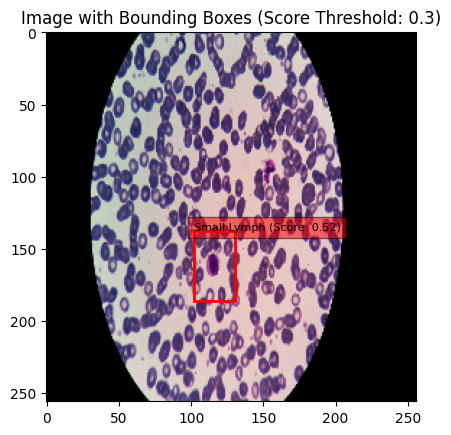

In [ ]:
image = image.resize((256,256), resample=Image.NEAREST)


# Display the image with bounding boxes for filtered predictions
fig, ax = plt.subplots(1)
ax.imshow(image)

for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
    box = box.cpu().numpy()
    score = score.item()
    label = label.item()

    # Extract box coordinates
    xmin, ymin, xmax, ymax = box

    # Set bounding box properties
    linewidth = 2
    color = 'r'
    edgecolor = 'r'
    linestyle = '-'

    # Add bounding box rectangle to the image
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                         color=color, linewidth=linewidth, edgecolor=edgecolor, linestyle=linestyle)
    ax.add_patch(rect)

    # Add label as text near the bounding box
    class_label = class_labels_id[label]
    text = f'{class_label} (Score: {score:.2f})'
    ax.text(xmin, ymin, text, fontsize=8, bbox=dict(facecolor=color, alpha=0.5))

plt.title('Image with Bounding Boxes (Score Threshold: 0.3)')
plt.show()

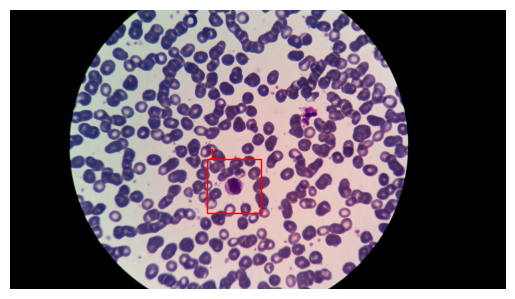

In [ ]:



# Read the annotation file
with open(annotation_file, 'r') as f:
    annotations = f.readlines()

import os
from PIL import Image
import matplotlib.pyplot as plt

# Initialize an empty list to store all the annotations
all_annotations = []

# Loop through each annotation and store them in the list
for annotation in annotations:
    # Split the annotation into class ID, coordinates, and remove any whitespace
    class_id, x_min, y_min, x_max, y_max = annotation.strip().split()

    # Convert coordinates to integers
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)

    # Store the annotation as a tuple in the list
    all_annotations.append((class_id, x_min, y_min, x_max, y_max))

# Read the corresponding image file
image = Image.open(image_path)

# Display the image
fig, ax = plt.subplots()
ax.imshow(image)

# Loop through all the annotations and add bounding box rectangles to the image
for annotation in all_annotations:
    class_id, x_min, y_min, x_max, y_max = annotation
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='r')
    ax.add_patch(rect)
    plt.text(x_min, y_min, class_id, color='r')

plt.axis('off')
plt.show()
